## Import necessary packages

In [2]:

# Import necessary libraries
%pip install imdlib
import imdlib as imd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report


Note: you may need to restart the kernel to use updated packages.


## Define parameters for data loading here, so that if data has already been dowloaded into respective directories only this and block with imd.open_data need to be run.

In [3]:
# Define parameters
start_yr = 2020
end_yr = 2023

# Define the target directory for rainfall data
rainfall_target_dir = './imd_data/rain'

# Define the target directory for rainfall data
tmin_target_dir = './imd_data/tmin'

# Define the target directory for rainfall data
tmax_target_dir = './imd_data/tmax'

## Download data from imdlib
This downloads all data to the working directory ('./') because I was having issues putting it in specific folders

In [ ]:
import os
import shutil
import imdlib as imd


# Define directories for each variable
directories = {
    'rain': './imd_data/rain',
    'tmin': './imd_data/tmin',
    'tmax': './imd_data/tmax'
}

# Ensure directories exist
for directory in directories.values():
    os.makedirs(directory, exist_ok=True)

# Step 1: Download data to the current directory
for variable in directories.keys():
    imd.get_data(variable, start_yr=start_yr, end_yr=end_yr, file_dir='.')  # Use current directory


## Move data to specified folder depending on the file name
I was having issues with the download just going in the './' directory no matter what I put as file_dir, so this manually moves the data files to their correct directory

In [ ]:

os.makedirs(rainfall_target_dir, exist_ok=True)  # Ensure the directory exists

# Step 2: Move files that start with 'Rainfall' to the specified directory
for file_name in os.listdir('.'):
    if file_name.startswith('Rainfall'):
        shutil.move(file_name, os.path.join(rainfall_target_dir, file_name))

print("Files starting with 'Rainfall' have been moved to:", rainfall_target_dir)



os.makedirs(tmin_target_dir, exist_ok=True)  # Ensure the directory exists

# Step 2: Move files that start with 'Rainfall' to the specified directory
for file_name in os.listdir('.'):
    if file_name.startswith('Mintemp'):
        shutil.move(file_name, os.path.join(tmin_target_dir, file_name))

print("Files starting with 'Mintemp' have been moved to:", tmin_target_dir)



os.makedirs(tmax_target_dir, exist_ok=True)  # Ensure the directory exists

# Step 2: Move files that start with 'Rainfall' to the specified directory
for file_name in os.listdir('.'):
    if file_name.startswith('Maxtemp'):
        shutil.move(file_name, os.path.join(tmax_target_dir, file_name))

print("Files starting with 'Maxtemp' have been moved to:", tmax_target_dir)

Files starting with 'Rainfall' have been moved to: ./imd_data/rain
Files starting with 'Mintemp' have been moved to: ./imd_data/tmin
Files starting with 'Maxtemp' have been moved to: ./imd_data/tmax


## Load data from the directories into variables

In [23]:
# Step 3: Load data from the correct directories
rain_data = imd.open_data('rain', start_yr, end_yr, file_dir=rainfall_target_dir)
tmin_data = imd.open_data('tmin', start_yr, end_yr, file_dir=tmin_target_dir)
tmax_data = imd.open_data('tmax', start_yr, end_yr, file_dir=tmax_target_dir)

In [24]:
# Convert indices to columns
rain_df = rain_data.get_xarray().sel(method='nearest').to_dataframe().reset_index()

# Convert indices to columns
tmin_df = tmin_data.get_xarray().sel(method='nearest').to_dataframe().reset_index()

# Convert indices to columns
tmax_df = tmax_data.get_xarray().sel(method='nearest').to_dataframe().reset_index()
tmax_df


,time,lat,lon,tmax
0,2020-01-01,7.5,67.5,99.900002
1,2020-01-01,7.5,68.5,99.900002
2,2020-01-01,7.5,69.5,99.900002
3,2020-01-01,7.5,70.5,99.900002
4,2020-01-01,7.5,71.5,99.900002
...,...,...,...,...
1404016,2023-12-31,37.5,93.5,99.900002
1404017,2023-12-31,37.5,94.5,99.900002
1404018,2023-12-31,37.5,95.5,99.900002
1404019,2023-12-31,37.5,96.5,99.900002


## Combine rain, tmin, and tmax dataframes into one single one based on the Date, Latitute, and Longitude
Also drop rows where rainfall = -999. This likely means data is not available

In [25]:
# Combine the datasets
combined_df = rain_df.merge(tmin_df, on=['time', 'lat', 'lon'], suffixes=('_rain', '_tmin'))
combined_df = combined_df.merge(tmax_df, on=['time', 'lat', 'lon'])
combined_df.rename(columns={'temp': 'tmax'}, inplace=True)
combined_df.columns = ['date', 'lat', 'lon', 'rainfall', 'tmin', 'tmax']
# Replace -999 with NaN for all columns
combined_df.replace(-999, pd.NA, inplace=True)

# Drop rows with any NaN values
combined_df.dropna(inplace=True)

combined_df


,date,lat,lon,rainfall,tmin,tmax
41,2020-01-01,8.5,77.5,0.0,24.009602,32.337498
71,2020-01-01,9.5,76.5,2.446286,22.791275,31.402376
72,2020-01-01,9.5,77.5,0.0,22.686659,30.923943
73,2020-01-01,9.5,78.5,0.0,21.944002,30.116961
102,2020-01-01,10.5,76.5,0.0,19.587202,28.477583
...,...,...,...,...,...,...
1403940,2023-12-31,35.5,79.5,0.0,-1.944666,99.900002
1403964,2023-12-31,36.5,72.5,0.0,0.159044,99.900002
1403965,2023-12-31,36.5,73.5,0.0,-1.565676,99.900002
1403966,2023-12-31,36.5,74.5,0.0,-1.005513,99.900002


## KNN ULT ATTEMPT

## Step 1, import libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.utils import resample

# Load Dataset
# Replace with the actual path to your dataset
# combined_df = pd.read_csv('path_to_your_file.csv')
combined_df.head()

,date,lat,lon,rainfall,tmin,tmax
41,2020-01-01,8.5,77.5,0.0,24.009602,32.337498
71,2020-01-01,9.5,76.5,2.446286,22.791275,31.402376
72,2020-01-01,9.5,77.5,0.0,22.686659,30.923943
73,2020-01-01,9.5,78.5,0.0,21.944002,30.116961
102,2020-01-01,10.5,76.5,0.0,19.587202,28.477583


## Step 2, feature engineering

In [35]:
# Feature Engineering: Retain highly correlated features and improve temporal patterns
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear
combined_df['year'] = pd.to_datetime(combined_df['date']).dt.year

# Calculate temperature difference (keep for potential non-linear effects)
combined_df['temp_diff'] = combined_df['tmax'] - combined_df['tmin']

# Retain rolling averages that correlate well with rainfall
combined_df['rainfall_rolling7'] = combined_df['rainfall'].rolling(window=7).mean()
combined_df['tmin_rolling7'] = combined_df['tmin'].rolling(window=7).mean()
combined_df['tmax_rolling7'] = combined_df['tmax'].rolling(window=7).mean()

# Drop rows with NaN caused by rolling calculations
combined_df.dropna(inplace=True)

# KMeans clustering for geographic grouping
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Display the processed dataset
combined_df.head()


,date,lat,lon,rainfall,tmin,tmax,month,day_of_year,year,temp_diff,rainfall_rolling7,temp_diff_rolling7,region,tmax_rolling7,tmin_rolling7
193,2020-01-01,13.5,74.5,0.0,17.903399,30.837086,1,1,2020,12.933687,0.864126,9.004279,2,28.904313,19.900034
194,2020-01-01,13.5,75.5,0.198225,17.950760,30.406975,1,1,2020,12.456215,0.509851,9.875634,2,28.963301,19.087667
195,2020-01-01,13.5,76.5,0.0,17.551579,28.533060,1,1,2020,10.981482,0.509851,9.954547,2,28.785026,18.830479
196,2020-01-01,13.5,77.5,0.0,18.646250,27.315321,1,1,2020,8.669071,0.509851,9.845856,2,28.974798,19.128942
197,2020-01-01,13.5,78.5,0.0,19.403454,27.837130,1,1,2020,8.433676,0.509851,9.874251,2,28.970657,19.096406


## Step 3, try to visualize a pattern

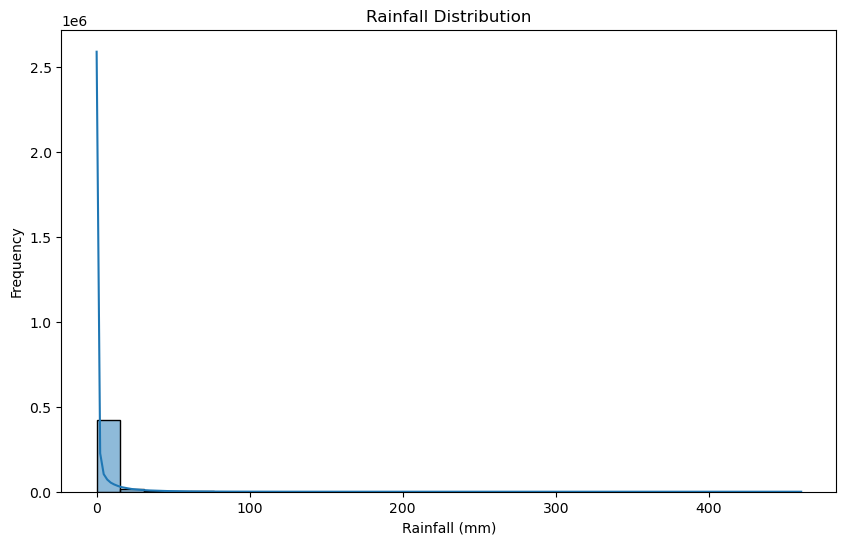

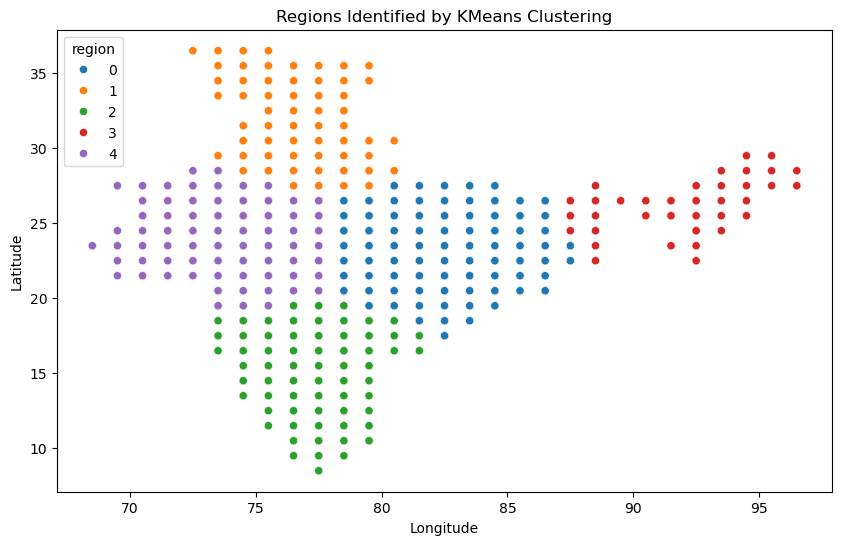

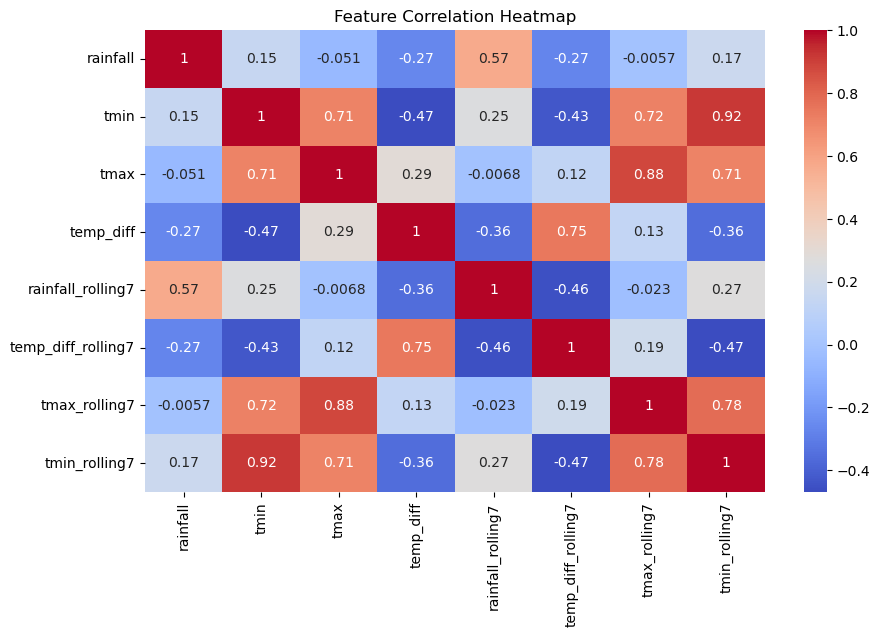

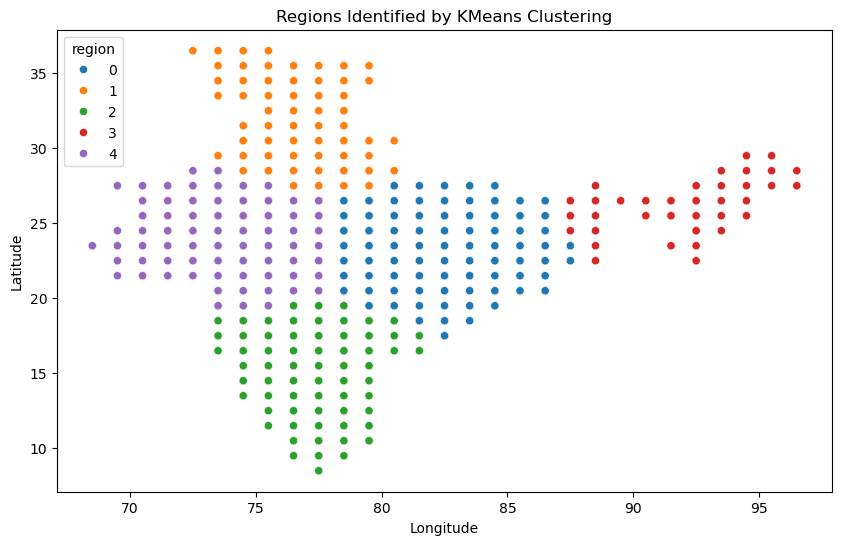

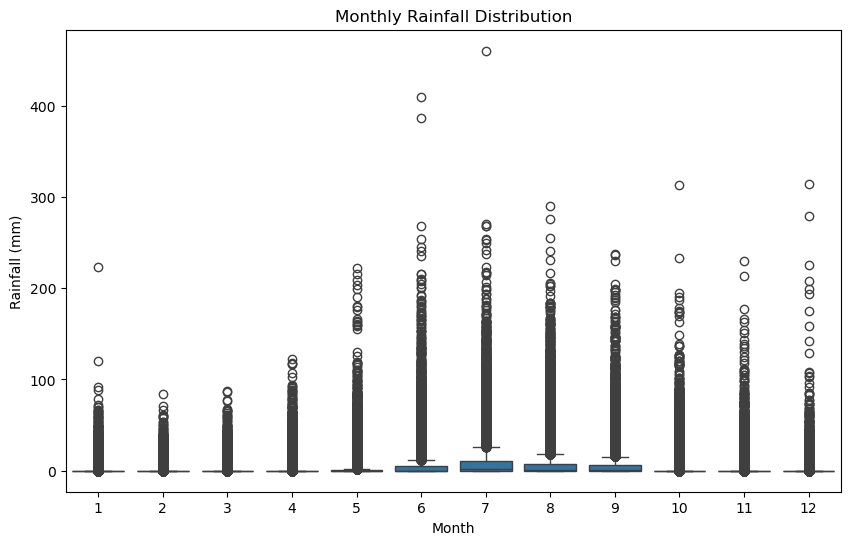

In [37]:
# Visualize rainfall distributions
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['rainfall'], bins=30, kde=True)
plt.title('Rainfall Distribution')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Frequency')
plt.show()

# Scatterplot for regions to understand clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='lon', y='lat', hue='region', palette='tab10')
plt.title('Regions Identified by KMeans Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Heatmap for correlation
plt.figure(figsize=(10, 6))
sns.heatmap(combined_df[['rainfall', 'tmin', 'tmax', 'temp_diff', 'rainfall_rolling7', 'temp_diff_rolling7', 'tmax_rolling7', 'tmin_rolling7']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Visualize KMeans clusters (regions)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='lon', y='lat', hue='region', palette='tab10')
plt.title('Regions Identified by KMeans Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Visualize rainfall trends over months
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='month', y='rainfall')
plt.title('Monthly Rainfall Distribution')
plt.xlabel('Month')
plt.ylabel('Rainfall (mm)')
plt.show()


## Step 4, categorize rainfall into classes

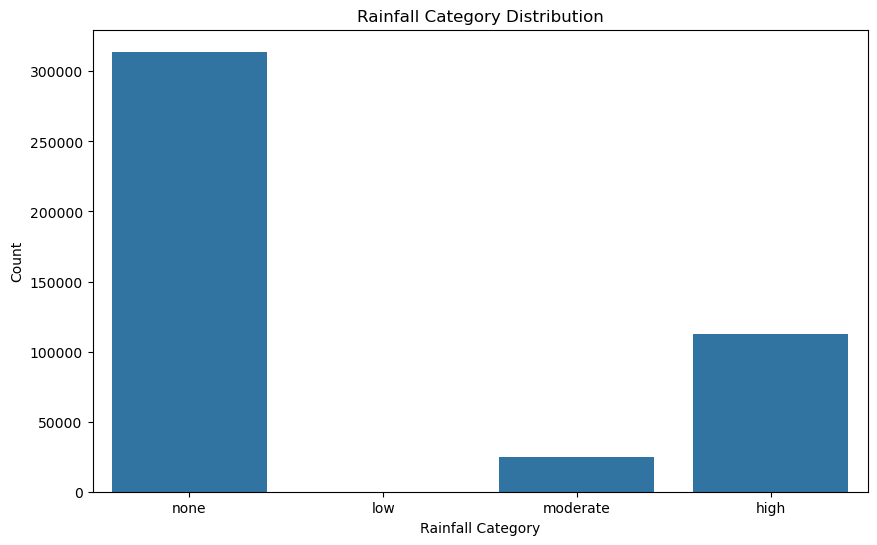

In [40]:
# Precompute quantiles once
rainfall_q1 = combined_df['rainfall'].quantile(0.25)
rainfall_q3 = combined_df['rainfall'].quantile(0.75)

# Define rainfall categories
def categorize_rainfall(value):
    if value == 0:
        return 'none'
    elif value <= rainfall_q1:
        return 'low'
    elif value <= rainfall_q3:
        return 'moderate'
    else:
        return 'high'

# Apply categorization
combined_df['rainfall_category'] = combined_df['rainfall'].apply(categorize_rainfall)

# Visualize the new class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='rainfall_category', order=['none', 'low', 'moderate', 'high'])
plt.title('Rainfall Category Distribution')
plt.xlabel('Rainfall Category')
plt.ylabel('Count')
plt.show()


## Step 5, get training and testing values (Feature Engineering and Selection)

In [41]:
# Select highly correlated features with rainfall
X = combined_df[['rainfall_rolling7', 'tmin_rolling7', 'tmax_rolling7', 'month', 'day_of_year', 'region']]
y = combined_df['rainfall_category']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

# Classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))

KNN Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.66      0.67     22572
    moderate       0.16      0.11      0.13      4909
        none       0.87      0.90      0.88     62805

    accuracy                           0.80     90286
   macro avg       0.57      0.56      0.56     90286
weighted avg       0.78      0.80      0.79     90286



## Retrying model with SMOTE

In [44]:
from imblearn.over_sampling import SMOTE

# Perform SMOTE on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train the model again with the balanced dataset
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn.fit(X_train_balanced, y_train_balanced)


y_pred = knn.predict(X_test)

# Classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))

KNN Classification Report:
              precision    recall  f1-score   support

        high       0.64      0.64      0.64     22572
    moderate       0.11      0.26      0.16      4909
        none       0.91      0.81      0.86     62805

    accuracy                           0.74     90286
   macro avg       0.55      0.57      0.55     90286
weighted avg       0.80      0.74      0.76     90286



## Attempting to re-train the KNN model using Optimal Combinations of Features

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from itertools import combinations
import warnings

warnings.filterwarnings('ignore')

# Load data (replace with actual dataset path)
# combined_df = pd.read_csv('path_to_your_file.csv')
combined_df.head()

,date,lat,lon,rainfall,tmin,tmax,month,day_of_year,year,temp_diff,rainfall_rolling7,temp_diff_rolling7,region,tmax_rolling7,tmin_rolling7,rainfall_category
193,2020-01-01,13.5,74.5,0.0,17.903399,30.837086,1,1,2020,12.933687,0.864126,9.004279,2,28.904313,19.900034,none
194,2020-01-01,13.5,75.5,0.198225,17.950760,30.406975,1,1,2020,12.456215,0.509851,9.875634,2,28.963301,19.087667,moderate
195,2020-01-01,13.5,76.5,0.0,17.551579,28.533060,1,1,2020,10.981482,0.509851,9.954547,2,28.785026,18.830479,none
196,2020-01-01,13.5,77.5,0.0,18.646250,27.315321,1,1,2020,8.669071,0.509851,9.845856,2,28.974798,19.128942,none
197,2020-01-01,13.5,78.5,0.0,19.403454,27.837130,1,1,2020,8.433676,0.509851,9.874251,2,28.970657,19.096406,none


In [46]:
# Preprocess temporal features
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear

# Add rolling features
combined_df['rainfall_rolling7'] = combined_df['rainfall'].rolling(window=7).mean()
combined_df['tmin_rolling7'] = combined_df['tmin'].rolling(window=7).mean()
combined_df['tmax_rolling7'] = combined_df['tmax'].rolling(window=7).mean()

# Add temperature difference
combined_df['temp_diff'] = combined_df['tmax'] - combined_df['tmin']

# Add regional clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Drop rows with NaN caused by rolling calculations
combined_df.dropna(inplace=True)

# Categorize rainfall based on quantiles
rainfall_q1 = combined_df['rainfall'].quantile(0.25)
rainfall_q3 = combined_df['rainfall'].quantile(0.75)

def categorize_rainfall(value):
    if value == 0:
        return 'none'
    elif value <= rainfall_q1:
        return 'low'
    elif value <= rainfall_q3:
        return 'moderate'
    else:
        return 'high'

combined_df['rainfall_category'] = combined_df['rainfall'].apply(categorize_rainfall)

## Generate Feature Combinations

In [47]:
# Generate interaction terms and add to dataset
feature_cols = ['rainfall_rolling7', 'tmin_rolling7', 'tmax_rolling7', 'temp_diff', 'month', 'region']
interaction_combinations = list(combinations(feature_cols, 2))

for comb in interaction_combinations:
    col_name = f"{comb[0]}_x_{comb[1]}"
    combined_df[col_name] = combined_df[comb[0]] * combined_df[comb[1]]

# Prepare the dataset for modeling
X = combined_df.drop(columns=['date', 'lat', 'lon', 'rainfall', 'rainfall_category'])
y = combined_df['rainfall_category']

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Feature Importance Visualization Using Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest to evaluate feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=1)
rf.fit(X_scaled, y)

# Permutation importance
perm_importance = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.show()

# Select top features for modeling
top_features = importance_df['Feature'].head(10).tolist()

## Convert numerical rainfall data into Categorical data. (None: 0, Low: 1-5, moderate: 6-20, high: 21+)
Attempted to find splits where each category had a somewhat equal size. 'None' still has the most values by far however causing bias towards it

In [8]:
# Binarize rainfall into categories
combined_df['rainfall_category'] = pd.cut(combined_df['rainfall'], bins=[-1, 0, 5, 20, np.inf], labels=['none', 'low', 'moderate', 'high'])
print(len(combined_df[combined_df['rainfall_category'] == 'none']))
print(len(combined_df[combined_df['rainfall_category'] == 'low']))
print(len(combined_df[combined_df['rainfall_category'] == 'moderate']))
print(len(combined_df[combined_df['rainfall_category'] == 'high']))

314038
72695
42794
21918



## Model Training and Testing

### K-Nearest Neighbors (KNN) Classification

Categorize rainfall into low, medium, and high intensity classes (low: 0-10, moderate 10-50, high: 50+). Trained KNN on tmin, tmax, lat, and lon.


In [10]:
# Train/test split
X = combined_df[['tmax', 'tmin', 'lat', 'lon']]
y = combined_df['rainfall_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN classification
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))


KNN Classification Report:
              precision    recall  f1-score   support

        high       0.34      0.33      0.33      4383
         low       0.35      0.34      0.34     14586
    moderate       0.28      0.19      0.23      8488
        none       0.84      0.88      0.86     62832

    accuracy                           0.70     90289
   macro avg       0.45      0.44      0.44     90289
weighted avg       0.69      0.70      0.69     90289



## KNN second attempt
Now training KNN on all previous attributes, plus month, day, and lags (which are attributes from the previous measurement/calendar day). Additionally, there was a major imbalance in the data, where the majority of the categories were 'low'. To counter this problem, I resampled the moderate and high to duplicate some of the data for equal sized categories in training

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


# Feature Engineering: Add month, day, and lag features
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['rainfall_lag1'] = combined_df['rainfall'].shift(1)
combined_df['tmin_lag1'] = combined_df['tmin'].shift(1)
combined_df['tmax_lag1'] = combined_df['tmax'].shift(1)

# Drop rows with NaN values caused by lag features
combined_df.dropna(inplace=True)

# Resample to balance classes
df_low = combined_df[combined_df['rainfall_category'] == 'low']
df_moderate = combined_df[combined_df['rainfall_category'] == 'moderate']
df_high = combined_df[combined_df['rainfall_category'] == 'high']

# Upsample the minority classes
df_moderate_upsampled = resample(df_moderate, replace=True, n_samples=len(df_low), random_state=42)
df_high_upsampled = resample(df_high, replace=True, n_samples=len(df_low), random_state=42)


# Combine to create a balanced dataset and shuffle it
balanced_df = pd.concat([df_low, df_moderate_upsampled, df_high_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare features (X) and target (y)
X = balanced_df[['tmax', 'tmin', 'lat', 'lon', 'month', 'day', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1']]
y = balanced_df['rainfall_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN classification with optimized n_neighbors
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))


KNN Classification Report:
              precision    recall  f1-score   support

        high       0.83      0.97      0.90      7255
         low       0.87      0.58      0.69      7237
    moderate       0.74      0.86      0.80      7317

    accuracy                           0.81     21809
   macro avg       0.81      0.81      0.80     21809
weighted avg       0.81      0.81      0.80     21809



314034
72694
42794
21918


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



# Feature Engineering: Add month, day, and lag features
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['rainfall_lag1'] = combined_df['rainfall'].shift(1)
combined_df['tmin_lag1'] = combined_df['tmin'].shift(1)
combined_df['tmax_lag1'] = combined_df['tmax'].shift(1)
combined_df['rainfall_lag2'] = combined_df['rainfall'].shift(2)
combined_df['tmin_lag2'] = combined_df['tmin'].shift(2)
combined_df['tmax_lag2'] = combined_df['tmax'].shift(2)
combined_df['rainfall_lag3'] = combined_df['rainfall'].shift(3)
combined_df['tmin_lag3'] = combined_df['tmin'].shift(3)
combined_df['tmax_lag3'] = combined_df['tmax'].shift(3)

# Drop rows with NaN values caused by lag features
combined_df.dropna(inplace=True)

# Split data into training and testing sets (before resampling)
X = combined_df[['tmax', 'tmin', 'lat', 'lon', 'month', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1', 'rainfall_lag2', 'tmin_lag2', 'tmax_lag2', 'rainfall_lag3', 'tmin_lag3', 'tmax_lag3']]
y = combined_df['rainfall_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Resample only on the training set to balance classes
train_df = pd.concat([X_train, y_train], axis=1)
df_none = train_df[train_df['rainfall_category'] == 'none']
df_low = train_df[train_df['rainfall_category'] == 'low']
df_moderate = train_df[train_df['rainfall_category'] == 'moderate']
df_high = train_df[train_df['rainfall_category'] == 'high']

# Upsample the minority classes in the training set
df_low_upsampled = resample(df_low, replace=True, n_samples=len(df_none), random_state=42)
df_moderate_upsampled = resample(df_moderate, replace=True, n_samples=len(df_none), random_state=42)
df_high_upsampled = resample(df_high, replace=True, n_samples=len(df_none), random_state=42)

# Combine to create a balanced training dataset and shuffle it
balanced_train_df = pd.concat([df_none, df_low_upsampled, df_moderate_upsampled, df_high_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target for the balanced training set
X_train_balanced = balanced_train_df.drop('rainfall_category', axis=1)
y_train_balanced = balanced_train_df['rainfall_category']

# Scale the features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# KNN classification with optimized n_neighbors
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train_balanced, y_train_balanced)
y_pred = knn.predict(X_test)

# Classification report
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))


KNN Classification Report:
              precision    recall  f1-score   support

        high       0.30      0.32      0.31      2208
         low       0.34      0.44      0.38      7258
    moderate       0.28      0.34      0.31      4325
        none       0.91      0.82      0.86     31354

    accuracy                           0.69     45145
   macro avg       0.46      0.48      0.47     45145
weighted avg       0.73      0.69      0.70     45145



## KNN Attempt 3

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

# Feature Engineering: Add month, day, lag features, and day of year
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear
combined_df['rainfall_lag1'] = combined_df['rainfall'].shift(1)
combined_df['tmin_lag1'] = combined_df['tmin'].shift(1)
combined_df['tmax_lag1'] = combined_df['tmax'].shift(1)
combined_df['rainfall_lag2'] = combined_df['rainfall'].shift(2)
combined_df['tmin_lag2'] = combined_df['tmin'].shift(2)
combined_df['tmax_lag2'] = combined_df['tmax'].shift(2)

# Drop rows with NaN values caused by lag features
combined_df.dropna(inplace=True)

# Clustering Latitude/Longitude into Regions
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Split data into features and target
X = combined_df[['tmax', 'tmin', 'month', 'day', 'day_of_year', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1',
                 'rainfall_lag2', 'tmin_lag2', 'tmax_lag2', 'region']]
y = combined_df['rainfall_category']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Try Different Scaling Methods
scaler = MinMaxScaler()  # Alternative: StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Perform Grid Search for Hyperparameter Tuning
params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_balanced, y_train_balanced)

# Best Model
knn = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Evaluate the Model
y_pred = knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Cross-Validation Accuracy
scores = cross_val_score(knn, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy:", scores.mean())


Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

# Feature Engineering: Add month, day, lag features, and day of year
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear
combined_df['rainfall_lag1'] = combined_df['rainfall'].shift(1)
combined_df['tmin_lag1'] = combined_df['tmin'].shift(1)
combined_df['tmax_lag1'] = combined_df['tmax'].shift(1)
combined_df['rainfall_lag2'] = combined_df['rainfall'].shift(2)
combined_df['tmin_lag2'] = combined_df['tmin'].shift(2)
combined_df['tmax_lag2'] = combined_df['tmax'].shift(2)

# Drop rows with NaN values caused by lag features
combined_df.dropna(inplace=True)

# Clustering Latitude/Longitude into Regions
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Add rolling averages for rainfall and temperature
combined_df['rainfall_rolling7'] = combined_df['rainfall'].rolling(window=7).mean()
combined_df['tmax_rolling7'] = combined_df['tmax'].rolling(window=7).mean()
combined_df['tmin_rolling7'] = combined_df['tmin'].rolling(window=7).mean()

# Drop rows with NaN values caused by rolling averages
combined_df.dropna(inplace=True)

# Update feature set
X = combined_df[['tmax', 'tmin', 'rainfall_rolling7', 'tmax_rolling7', 'tmin_rolling7', 
                 'month', 'day', 'day_of_year', 'region']]
y = combined_df['rainfall_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)



In [12]:
# Try Random Forest for better performance
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_params, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_balanced, y_train_balanced)

# Best Model
rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Evaluate the Model
y_pred = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [14]:
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering: Add lag features, rolling averages, and seasonal features
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear

# Add lag features for rainfall and temperature
for lag in range(1, 4):  # Create 3 lag features
    combined_df[f'rainfall_lag{lag}'] = combined_df['rainfall'].shift(lag)
    combined_df[f'tmin_lag{lag}'] = combined_df['tmin'].shift(lag)
    combined_df[f'tmax_lag{lag}'] = combined_df['tmax'].shift(lag)

# Add rolling averages
combined_df['rainfall_rolling7'] = combined_df['rainfall'].rolling(window=7).mean()
combined_df['tmax_rolling7'] = combined_df['tmax'].rolling(window=7).mean()
combined_df['tmin_rolling7'] = combined_df['tmin'].rolling(window=7).mean()

# Drop rows with NaN values caused by lagging and rolling features
combined_df.dropna(inplace=True)

# Clustering Latitude/Longitude into Regions (KMeans)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Define Features and Target
X = combined_df[['tmax', 'tmin', 'rainfall_rolling7', 'tmax_rolling7', 'tmin_rolling7', 
                 'month', 'day', 'day_of_year', 'region',
                 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3',
                 'tmin_lag1', 'tmin_lag2', 'tmin_lag3',
                 'tmax_lag1', 'tmax_lag2', 'tmax_lag3']]
y = combined_df['rainfall_category']

# Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# LightGBM Classifier with Hyperparameter Tuning
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 20, 30],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [20, 50, 100]
}

lgbm = LGBMClassifier(random_state=42)
grid = GridSearchCV(lgbm, param_grid=lgbm_params, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid.fit(X_train_balanced, y_train_balanced)

# Best Model
best_lgbm = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Evaluate the Best Model
y_pred = best_lgbm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Cross-Validation Score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_lgbm, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print("\nCross-Validation F1 Macro Score:", np.mean(cv_scores))


KeyboardInterrupt: 

## Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Split data into training and testing sets (before resampling)
X = combined_df[['tmax', 'tmin', 'lat', 'lon', 'month', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1', 'rainfall_lag2', 'tmin_lag2', 'tmax_lag2', 'rainfall_lag3', 'tmin_lag3', 'tmax_lag3']]
y = combined_df['rainfall_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample only on the training set to balance classes
train_df = pd.concat([X_train, y_train], axis=1)
df_none = train_df[train_df['rainfall_category'] == 'none']
df_low = train_df[train_df['rainfall_category'] == 'low']
df_moderate = train_df[train_df['rainfall_category'] == 'moderate']
df_high = train_df[train_df['rainfall_category'] == 'high']

# Upsample the minority classes in the training set
df_low_upsampled = resample(df_low, replace=True, n_samples=len(df_none), random_state=42)
df_moderate_upsampled = resample(df_moderate, replace=True, n_samples=len(df_none), random_state=42)
df_high_upsampled = resample(df_high, replace=True, n_samples=len(df_none), random_state=42)

# Combine to create a balanced training dataset and shuffle it
balanced_train_df = pd.concat([df_none, df_low_upsampled, df_moderate_upsampled, df_high_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target for the balanced training set
X_train_balanced = balanced_train_df.drop('rainfall_category', axis=1)
y_train_balanced = balanced_train_df['rainfall_category']

# Scale the features
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression model with increased max_iter and 'saga' solver
log_regression = LogisticRegression(max_iter=500, solver='saga', verbose=True)
log_regression.fit(X_train_balanced, y_train_balanced)

# Predictions and evaluation
y_pred = log_regression.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1, change: 1.00000000
Epoch 2, change: 0.04472426
Epoch 3, change: 0.01598814
Epoch 4, change: 0.00974481
Epoch 5, change: 0.00903399
Epoch 6, change: 0.00502258
Epoch 7, change: 0.00329183
Epoch 8, change: 0.00082156
Epoch 9, change: 0.00299354
Epoch 10, change: 0.00282960
Epoch 11, change: 0.00020037
Epoch 12, change: 0.00013768
convergence after 13 epochs took 10 seconds
Logistic Regression Classification Report:
              precision    recall  f1-score   support

        high       0.30      0.58      0.39      4393
         low       0.30      0.41      0.34     14672
    moderate       0.30      0.24      0.27      8451
        none       0.91      0.79      0.84     62768

    accuracy                           0.67     90284
   macro avg       0.45      0.51      0.46     90284
weighted avg       0.72      0.67      0.69     90284



In [60]:
df_moderate_upsampled

,tmax,tmin,lat,lon,month,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,rainfall_lag3,tmin_lag3,tmax_lag3,rainfall_category
308148,24.468172,14.482224,27.5,75.5,11,0.0,15.376560,26.026825,0.0,14.856816,26.467449,0.0,15.147067,27.592621,moderate
189792,31.170446,22.925371,22.5,77.5,7,9.143746,23.060347,30.848644,16.895939,22.706800,30.492731,6.992356,23.237637,30.964306,moderate
420468,29.564405,16.483616,23.5,82.5,3,2.960067,15.632604,30.064024,8.677505,15.744436,31.453554,11.182627,15.337174,31.679895,moderate
497591,27.069975,16.277550,31.5,77.5,6,10.857388,17.239813,29.172094,1.70381,20.610767,32.110329,4.501268,21.542048,33.946007,moderate
1282495,29.373991,23.519861,23.5,92.5,8,50.799137,23.568340,29.370785,3.39203,26.455067,34.107105,2.619591,25.403633,34.175896,moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643911,29.558029,23.411194,8.5,77.5,11,0.0,5.514454,19.850872,0.0,5.135349,19.743677,0.0,4.580077,18.865578,moderate
575431,28.582174,21.826008,31.5,76.5,8,0.0,24.217270,30.366285,1.344704,24.913584,32.559273,18.695019,21.341101,26.314484,moderate
1307436,29.258955,22.292782,22.5,78.5,9,32.404373,22.208860,29.757603,67.861443,22.050854,30.273502,0.424304,22.130777,30.191908,moderate
1290758,33.298981,25.200878,11.5,78.5,9,0.02994,21.341215,28.770288,0.0,20.340857,27.717375,18.252485,21.252438,27.248331,moderate


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Random Forest classification with balanced training data
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf.predict(X_test)

# Classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

        high       0.53      0.34      0.41      2165
         low       0.44      0.49      0.47      7354
    moderate       0.38      0.34      0.36      4216
        none       0.90      0.91      0.91     31407

    accuracy                           0.76     45142
   macro avg       0.56      0.52      0.54     45142
weighted avg       0.76      0.76      0.76     45142




### ReLU Neural Network for Regression

We will train a ReLU-based neural network to predict daily rainfall amounts.


In [51]:
# Split data into training and testing sets (before resampling)
X = combined_df[['tmax', 'tmin', 'lat', 'lon', 'month', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1', 'rainfall_lag2', 'tmin_lag2', 'tmax_lag2', 'rainfall_lag3', 'tmin_lag3', 'tmax_lag3']]
y = combined_df['rainfall']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Resample only on the training set to balance classes
train_df = pd.concat([X_train, y_train], axis=1)

df_none = train_df[train_df['rainfall'] <= 0]
df_low = train_df[(train_df['rainfall'] >= 1) & (train_df['rainfall'] <= 5)]
df_moderate = train_df[(train_df['rainfall'] >= 6) & (train_df['rainfall'] <= 20)]
df_high = train_df[train_df['rainfall'] > 20]

# Upsample the minority classes in the training set
df_low_upsampled = resample(df_low, replace=True, n_samples=len(df_none), random_state=42)
df_moderate_upsampled = resample(df_moderate, replace=True, n_samples=len(df_none), random_state=42)
df_high_upsampled = resample(df_high, replace=True, n_samples=len(df_none), random_state=42)

# Combine to create a balanced training dataset and shuffle it
balanced_train_df = pd.concat([df_none, df_low_upsampled, df_moderate_upsampled, df_high_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target for the balanced training set
X_train_balanced = balanced_train_df.drop('rainfall', axis=1)
y_train_balanced = balanced_train_df['rainfall']



# Neural network regression
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42, verbose=True)
mlp.fit(X_train_balanced, y_train_balanced)
y_pred_nn = mlp.predict(X_test)

# Model performance
print("Neural Network Mean Squared Error:", mean_squared_error(y_test, y_pred_nn))
print("Neural Network R-squared:", r2_score(y_test, y_pred_nn))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Neural Network Mean Squared Error: 99.74721447451864
Neural Network R-squared: 0.17847668872686462


In [49]:
train_df[(train_df['rainfall'] >= 1) & (train_df['rainfall'] <= 5)]

,tmax,tmin,lat,lon,month,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,rainfall_lag3,tmin_lag3,tmax_lag3,rainfall
1233506,33.500629,25.851522,24.5,83.5,7,11.457508,26.260187,33.184647,6.314296,26.018789,32.774895,20.407169,25.597666,32.858776,4.767361
69912,22.160629,8.690793,30.5,74.5,3,3.041445,15.788067,30.918373,4.156647,16.041580,30.595781,6.430786,10.608399,19.546478,4.828847
1264558,30.699596,19.973892,34.5,73.5,8,0.0,18.625856,27.753078,0.001003,19.790253,30.207409,2.366238,20.289574,30.420904,1.17993
1169046,33.820515,22.628618,22.5,72.5,5,0.0,23.126904,33.892773,0.047061,22.913815,31.883038,0.0,22.908373,31.278032,1.917958
612102,29.371477,16.738756,36.5,74.5,9,6.417793,15.907810,28.610575,7.690259,16.826775,29.499233,0.0,14.303546,26.999653,1.624089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086996,31.438076,21.369711,10.5,79.5,2,0.0,20.793087,32.266541,0.0,18.465057,30.515810,0.0,18.030764,30.152756,4.727511
204381,32.944904,23.809467,27.5,96.5,7,5.356512,24.088800,32.993355,2.164036,24.097441,32.973579,9.242778,24.689068,32.823479,2.077559
385186,8.659752,3.233021,32.5,78.5,2,6.177868,3.179184,9.396719,6.813626,5.265955,11.882030,4.767539,5.560972,13.384615,3.180301
8568,4.364387,-6.854029,35.5,79.5,1,5.430208,-6.226419,5.599256,4.550791,-5.436159,6.039911,4.928485,-5.374222,6.051902,4.222765



### Linear Regression


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = combined_df[['lat', 'lon', 'tmin', 'tmax']]
y = combined_df['rainfall']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = linear_model.predict(X_test)
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("Linear Regression R-squared:", r2_score(y_test, y_pred))


Linear Regression MSE: 109.48438971541853
Linear Regression R-squared: 0.07727972699717311


## Logistic Regression

In [ ]:
X_train_balanced

,tmax,tmin,lat,lon,month,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,rainfall_lag3,tmin_lag3,tmax_lag3
0,46.000481,26.811592,24.5,78.5,5,0.0,26.997257,46.193928,0.0,28.839128,45.688316,0.0,28.982134,45.613052
1,30.434790,23.616657,17.5,81.5,8,4.130811,24.045216,30.723562,16.629883,23.781025,30.715736,3.576759,22.735800,30.106403
2,27.959087,11.998921,28.5,73.5,12,0.0,12.223704,28.289671,0.0,13.613625,25.535789,0.0,13.310403,25.836740
3,30.460081,20.127975,23.5,91.5,5,0.0,24.504341,34.566147,0.0,23.393032,34.645550,0.0,23.322351,35.077496
4,30.949936,22.337227,14.5,74.5,10,27.893852,24.355722,33.198692,0.0,22.487925,30.801878,0.0,21.073111,29.058229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004983,27.390507,22.359585,15.5,77.5,8,0.0,21.674887,26.032665,1.513872,21.746965,26.134336,20.548386,22.873724,26.541073
1004984,30.177738,24.224222,19.5,73.5,7,0.0,24.982695,32.657612,26.220745,24.828444,32.353474,12.275237,24.156969,32.357563
1004985,34.371857,21.281370,13.5,75.5,3,0.0,21.976992,34.199097,0.0,23.776783,35.872559,0.0,21.918341,36.442924
1004986,28.143435,23.871866,24.5,79.5,8,10.547924,23.711760,28.083920,26.4995,23.463823,28.536638,5.135821,23.827614,28.776018


## Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R-squared:", r2_score(y_test, y_pred_rf))


Random Forest MSE: 87.05188626268406
Random Forest R-squared: 0.26633796410153543


## LGBM Classifier Model

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering: Add lag features, rolling averages, and seasonal features
combined_df['month'] = pd.to_datetime(combined_df['date']).dt.month
combined_df['day'] = pd.to_datetime(combined_df['date']).dt.day
combined_df['day_of_year'] = pd.to_datetime(combined_df['date']).dt.dayofyear


# Add rolling averages
combined_df['rainfall_rolling7'] = combined_df['rainfall'].rolling(window=7).mean()
combined_df['tmax_rolling7'] = combined_df['tmax'].rolling(window=7).mean()
combined_df['tmin_rolling7'] = combined_df['tmin'].rolling(window=7).mean()

# Drop rows with NaN values caused by lagging and rolling features
combined_df.dropna(inplace=True)

# Clustering Latitude/Longitude into Regions (KMeans)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
combined_df['region'] = kmeans.fit_predict(combined_df[['lat', 'lon']])

# Define Features and Target
X = combined_df[['tmax', 'tmin', 'rainfall_rolling7', 'tmax_rolling7', 'tmin_rolling7', 
                 'month', 'day', 'day_of_year', 'region']]
y = combined_df['rainfall_category']

# Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=20, num_leaves=50, min_child_samples=50)
# lgbm.fit(X_train_balanced, y_train_balanced)

rf = RandomForestClassifier()
rf.fit(X_train_balanced, y_train_balanced)


# Evaluate the Best Model
y_pred = rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Cross-Validation Score
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=5, scoring='f1_macro')
print("\nCross-Validation F1 Macro Score:", np.mean(cv_scores))



Classification Report:
              precision    recall  f1-score   support

        high       0.40      0.61      0.48      2223
         low       0.43      0.53      0.47      7274
    moderate       0.36      0.43      0.40      4380
        none       0.95      0.84      0.89     31263

    accuracy                           0.74     45140
   macro avg       0.54      0.60      0.56     45140
weighted avg       0.78      0.74      0.76     45140


Confusion Matrix:
[[ 1348   250   596    29]
 [  664  3847  1712  1051]
 [ 1011  1266  1905   198]
 [  347  3666  1045 26205]]


KeyboardInterrupt: 

In [21]:
combined_df

,date,lat,lon,rainfall,tmin,tmax,rainfall_category,rainfall_rolling7,tmax_rolling7,tmin_rolling7,...,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,region,rainfall_lag3,tmin_lag3,tmax_lag3
323,2020-01-01,17.5,80.5,0.0,19.235058,29.196823,none,0.099119,29.741392,17.587688,...,0.0,18.512239,29.587257,0.693836,18.468491,29.201584,2,0.0,18.781193,29.415958
324,2020-01-01,17.5,81.5,0.0,18.850029,28.696348,none,0.099119,29.564647,18.214310,...,0.0,19.235058,29.196823,0.0,18.512239,29.587257,2,0.693836,18.468491,29.201584
325,2020-01-01,17.5,82.5,0.0,18.546305,28.216099,none,0.099119,29.185534,18.599740,...,0.0,18.850029,28.696348,0.0,19.235058,29.196823,4,0.0,18.512239,29.587257
347,2020-01-01,18.5,73.5,0.0,14.870060,28.821758,none,0.099119,29.019404,18.180482,...,0.0,18.546305,28.216099,0.0,18.850029,28.696348,2,0.0,19.235058,29.196823
348,2020-01-01,18.5,74.5,0.0,13.588509,29.562149,none,0.099119,29.040288,17.438670,...,0.0,14.870060,28.821758,0.0,18.546305,28.216099,2,0.0,18.850029,28.696348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403940,2023-12-31,35.5,79.5,0.0,-1.944666,99.900002,none,0.000000,36.806536,-0.101008,...,0.0,-1.312094,99.900002,0.0,0.251967,11.555274,3,0.0,0.281791,11.589058
1403964,2023-12-31,36.5,72.5,0.0,0.159044,99.900002,none,0.000000,49.426408,-0.183001,...,0.0,-1.944666,99.900002,0.0,-1.312094,99.900002,3,0.0,0.251967,11.555274
1403965,2023-12-31,36.5,73.5,0.0,-1.565676,99.900002,none,0.000000,62.044433,-0.502005,...,0.0,0.159044,99.900002,0.0,-1.944666,99.900002,3,0.0,-1.312094,99.900002
1403966,2023-12-31,36.5,74.5,0.0,-1.005513,99.900002,none,0.000000,74.663477,-0.733592,...,0.0,-1.565676,99.900002,0.0,0.159044,99.900002,3,0.0,-1.944666,99.900002


In [37]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Copy combined_df to avoid modifying the original data
df = combined_df.copy()

# Feature Engineering
# Extract month and day from date
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

# Create lag features for rainfall, tmin, and tmax (using 1-day lag as an example)
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['tmin_lag1'] = df['tmin'].shift(1)
df['tmax_lag1'] = df['tmax'].shift(1)

# Additional lag features (optional)
# df['rainfall_lag2'] = df['rainfall'].shift(2)  # 2-day lag
# df['tmin_lag2'] = df['tmin'].shift(2)
# df['tmax_lag2'] = df['tmax'].shift(2)

# Drop rows with NaN values caused by shifting (for the first row or two)
df.dropna(inplace=True)

# Prepare features (X) and target (y)
X = df[['lat', 'lon', 'tmin', 'tmax', 'month', 'day', 'rainfall_lag1', 'tmin_lag1', 'tmax_lag1']]
y = df['rainfall']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest with Temporal Features - Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Random Forest with Temporal Features - R-squared:", r2_score(y_test, y_pred))


Random Forest with Temporal Features - Mean Squared Error: 72.53472527327952
Random Forest with Temporal Features - R-squared: 0.38619406314045823


In [39]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Copy combined_df to avoid modifying the original data
df = combined_df.copy()

# Feature Engineering
# Extract month and day from date to account for seasonality
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

# Create lag features for rainfall, tmin, and tmax (1-day and 2-day lags)
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['tmin_lag1'] = df['tmin'].shift(1)
df['tmax_lag1'] = df['tmax'].shift(1)

df['rainfall_lag2'] = df['rainfall'].shift(2)
df['tmin_lag2'] = df['tmin'].shift(2)
df['tmax_lag2'] = df['tmax'].shift(2)

# Drop rows with NaN values caused by shifting (for the first two rows in this case)
df.dropna(inplace=True)

# Prepare features (X) and target (y)
X = df[['lat', 'lon', 'tmin', 'tmax', 'month', 'day', 
        'rainfall_lag1', 'tmin_lag1', 'tmax_lag1', 
        'rainfall_lag2', 'tmin_lag2', 'tmax_lag2']]
y = df['rainfall']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting with Lag Features - Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Gradient Boosting with Lag Features - R-squared:", r2_score(y_test, y_pred))


Gradient Boosting with Lag Features - Mean Squared Error: 77.99471260690511
Gradient Boosting with Lag Features - R-squared: 0.36711030259973465


In [ ]:
%pip install xgboost

In [45]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Copy combined_df to avoid modifying the original data
df = combined_df.copy()

# Feature Engineering
# Extract month and day from date to account for seasonality
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

# Create lag features and rolling averages for rainfall, tmin, and tmax
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['tmin_lag1'] = df['tmin'].shift(1)
df['tmax_lag1'] = df['tmax'].shift(1)

df['rainfall_lag2'] = df['rainfall'].shift(2)
df['tmin_lag2'] = df['tmin'].shift(2)
df['tmax_lag2'] = df['tmax'].shift(2)

# Rolling averages (3-day average)
df['rainfall_3day_avg'] = df['rainfall'].shift(1).rolling(window=3).mean()
df['tmin_3day_avg'] = df['tmin'].shift(1).rolling(window=3).mean()
df['tmax_3day_avg'] = df['tmax'].shift(1).rolling(window=3).mean()

# Drop rows with NaN values caused by shifting and rolling
df.dropna(inplace=True)

# Ensure all features are numeric
numeric_columns = ['rainfall_lag1', 'rainfall_lag2', 'tmin_lag1', 'tmin_lag2', 
                   'tmax_lag1', 'tmax_lag2', 'rainfall_3day_avg', 
                   'tmin_3day_avg', 'tmax_3day_avg']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any remaining rows with NaN values (if there are any left after conversion)
df.dropna(inplace=True)

# Prepare features (X) and target (y)
X = df[['lat', 'lon', 'tmin', 'tmax', 'month', 'day', 
        'rainfall_lag1', 'tmin_lag1', 'tmax_lag1', 
        'rainfall_lag2', 'tmin_lag2', 'tmax_lag2', 
        'rainfall_3day_avg', 'tmin_3day_avg', 'tmax_3day_avg']]
y = df['rainfall']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


# Evaluate the model
print("XGBoost with Lag Features and Rolling Averages - Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("XGBoost with Lag Features and Rolling Averages - R-squared:", r2_score(y_test, y_pred))


XGBoost with Lag Features and Rolling Averages - Mean Squared Error: 72.93159667576857
XGBoost with Lag Features and Rolling Averages - R-squared: 0.3879686865545823


In [22]:
combined_df

,date,lat,lon,rainfall,tmin,tmax,rainfall_category,rainfall_rolling7,tmax_rolling7,tmin_rolling7,...,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,region,rainfall_lag3,tmin_lag3,tmax_lag3
323,2020-01-01,17.5,80.5,0.0,19.235058,29.196823,none,0.099119,29.741392,17.587688,...,0.0,18.512239,29.587257,0.693836,18.468491,29.201584,2,0.0,18.781193,29.415958
324,2020-01-01,17.5,81.5,0.0,18.850029,28.696348,none,0.099119,29.564647,18.214310,...,0.0,19.235058,29.196823,0.0,18.512239,29.587257,2,0.693836,18.468491,29.201584
325,2020-01-01,17.5,82.5,0.0,18.546305,28.216099,none,0.099119,29.185534,18.599740,...,0.0,18.850029,28.696348,0.0,19.235058,29.196823,4,0.0,18.512239,29.587257
347,2020-01-01,18.5,73.5,0.0,14.870060,28.821758,none,0.099119,29.019404,18.180482,...,0.0,18.546305,28.216099,0.0,18.850029,28.696348,2,0.0,19.235058,29.196823
348,2020-01-01,18.5,74.5,0.0,13.588509,29.562149,none,0.099119,29.040288,17.438670,...,0.0,14.870060,28.821758,0.0,18.546305,28.216099,2,0.0,18.850029,28.696348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403940,2023-12-31,35.5,79.5,0.0,-1.944666,99.900002,none,0.000000,36.806536,-0.101008,...,0.0,-1.312094,99.900002,0.0,0.251967,11.555274,3,0.0,0.281791,11.589058
1403964,2023-12-31,36.5,72.5,0.0,0.159044,99.900002,none,0.000000,49.426408,-0.183001,...,0.0,-1.944666,99.900002,0.0,-1.312094,99.900002,3,0.0,0.251967,11.555274
1403965,2023-12-31,36.5,73.5,0.0,-1.565676,99.900002,none,0.000000,62.044433,-0.502005,...,0.0,0.159044,99.900002,0.0,-1.944666,99.900002,3,0.0,-1.312094,99.900002
1403966,2023-12-31,36.5,74.5,0.0,-1.005513,99.900002,none,0.000000,74.663477,-0.733592,...,0.0,-1.565676,99.900002,0.0,0.159044,99.900002,3,0.0,-1.944666,99.900002


In [40]:
train_df

,tmax,tmin,lat,lon,month,rainfall_lag1,tmin_lag1,tmax_lag1,rainfall_lag2,tmin_lag2,tmax_lag2,rainfall_lag3,tmin_lag3,tmax_lag3,rainfall_category
433849,39.035294,20.086781,21.5,71.5,3,0.0,20.347363,38.158993,0.0,20.513731,37.283146,0.0,23.845798,35.761120,none
1020281,28.124092,8.978289,28.5,76.5,11,0.0,8.901142,28.330221,0.0,8.472496,28.702677,0.0,9.134565,29.421640,none
647816,27.643621,20.068008,10.5,76.5,11,3.182608,22.356794,30.519241,58.583172,22.098606,30.755178,8.721501,22.097355,30.525640,moderate
1067239,23.386459,7.951762,24.5,69.5,1,0.0,11.040932,22.044653,0.0,11.331120,22.714642,0.0,14.595883,25.130690,none
1109618,34.603153,17.637062,27.5,71.5,2,0.0,17.925789,34.915749,0.0,18.136454,35.631111,0.0,13.916739,27.527790,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806011,35.773399,17.519110,29.5,78.5,4,0.0,20.149632,39.386261,0.0,21.397463,41.377182,0.0,21.108980,41.571579,none
1137959,36.676746,25.116705,11.5,78.5,3,0.0,21.302917,33.741489,3.965574,20.317877,32.300201,0.0,21.201389,31.972261,none
410540,32.778442,19.468470,13.5,74.5,3,0.0,20.043310,33.969254,0.0,17.795572,34.298820,0.0,17.651436,33.027950,none
456953,39.715446,21.961395,22.5,80.5,4,0.0,21.698277,39.242443,0.0,21.648506,39.592129,0.0,22.112253,39.869778,none
